In [4]:
import sys
sys.path.append("..")

import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
from src.graphgen.synthetic_graph_dataset_PyG import *
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv, GraphConv, global_mean_pool, global_add_pool
from captum.attr import Saliency, IntegratedGradients

In [3]:
dataset = SyntheticGraphDatasetPyG('graphGenDataset8000.pkl')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')
print(f'Class label: ', data.y)
print(f'Motifs: {data.motifs}')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}') # divide by 2 because of undirected edges
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: SyntheticGraphDatasetPyG(8000):
Number of graphs: 8000
Number of features: 10

Data(x=[29, 10], edge_index=[2, 220], y=[1], motifs=[1])
Class label:  tensor([1])
Motifs: [[6, 13, 22, 19, 26]]
Number of nodes: 29
Number of edges: 110.0
Average node degree: 7.59
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
## verify the dataset

# with open('graphGenDataset100.pkl', 'rb') as f:
#     dd = pickle.load(f)

# gg = nx.Graph(dd[0][0])
# nx.draw_networkx(gg, pos=nx.spring_layout(gg))

# print(f'nodes: {len(gg.nodes())}')
# print(f'edges: {len(gg.edges())}')
# print(f'label: {dd[0][3]}')


In [6]:
# Split the dataset into training, validation, and testing subsets
num_samples = len(dataset)
num_train = int(0.7 * num_samples)
num_val = int(0.2 * num_samples)
num_test = num_samples - num_train - num_val

# TODO: stratified sampling
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

print(len(train_dataset), len(val_dataset), len(test_dataset))
# check class-wise distribution of validation set
for i in train_dataset, val_dataset, test_dataset:
    labels = [label[1].item() for _,_, label, _ in i]
    print(Counter(labels))

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


5600 1600 800
Counter({0: 2814, 1: 2786})
Counter({0: 805, 1: 795})
Counter({1: 415, 0: 385})


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model Training

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [15]:
class GraphConvNet(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()

        num_features = dataset.num_features
        self.dim = dim

        #TODO: add batchnorm (& residual connections)
        #TODO: experiment with different number of layers
        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

model = GraphConvNet(dim=32).to(device)
print(model)

GraphConvNet(
  (conv1): GraphConv(10, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 32)
  (conv5): GraphConv(32, 32)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [16]:
# Training loop with validation and model checkpointing
best_val_loss = float("inf")  # Track the best validation loss
best_model = None

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 11):
    model.train()
    train_loss = 0
    train_correct = 0

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        train_correct += pred.eq(data.y).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    model.eval()
    val_loss = 0
    val_correct = 0
    for data in val_loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        val_loss += loss.item()
        pred = output.argmax(dim=1)
        val_correct += pred.eq(data.y).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'graphgen_best_model.pt')

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

# Load the best model for evaluation
model.load_state_dict(torch.load('graphgen_best_model.pt'))

Epoch: 001, Train Loss: 8.3302, Train Acc: 0.8359, Val Loss: 0.1638, Val Acc: 0.9663
Epoch: 002, Train Loss: 0.1912, Train Acc: 0.9332, Val Loss: 0.1549, Val Acc: 0.9669
Epoch: 003, Train Loss: 0.1572, Train Acc: 0.9518, Val Loss: 0.1003, Val Acc: 0.9762
Epoch: 004, Train Loss: 0.1477, Train Acc: 0.9455, Val Loss: 0.1019, Val Acc: 0.9675
Epoch: 005, Train Loss: 0.1874, Train Acc: 0.9336, Val Loss: 0.1934, Val Acc: 0.9725
Epoch: 006, Train Loss: 0.1498, Train Acc: 0.9491, Val Loss: 0.1137, Val Acc: 0.9781
Epoch: 007, Train Loss: 0.1509, Train Acc: 0.9477, Val Loss: 0.1531, Val Acc: 0.8869
Epoch: 008, Train Loss: 0.1269, Train Acc: 0.9589, Val Loss: 0.1098, Val Acc: 0.9731
Epoch: 009, Train Loss: 0.1418, Train Acc: 0.9493, Val Loss: 0.0953, Val Acc: 0.9363
Epoch: 010, Train Loss: 0.0966, Train Acc: 0.9500, Val Loss: 0.0558, Val Acc: 0.9694


<All keys matched successfully>

In [17]:
# ... (Use the model for evaluation)
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9688


## Model Interpretability

In [18]:
def model_forward(edge_mask, data):
    """
    Forward pass through the model with masked edges.
    edge_mask: torch.tensor of shape (num_edges,)
    data: PyG data object
    """
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    """
    Explain the model's prediction using the given explanation method.
    method: 'ig' or 'saliency'
    data: PyG data object
    target: target class label
    """
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [44]:
def visualize_graph(graph, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges
    edges = graph.edge_index.t().tolist()
    G.add_edges_from(edges)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph_x = graph.x.cpu().detach().numpy()
    node_labels = {i:graph_x[i].argmax() for i in range(len(graph_x))}
    # there is only one motif in the list for this binary classification problem
    node_colors = ['lightcoral' if node in graph.motifs[0] else 'skyblue' for node in G.nodes]

    # Draw the original graph
    nx.draw_networkx(G, pos, labels=node_labels, node_color=node_colors, ax=ax)

    ax.set_title("Original Graph")

def visualize_attributions(graph, attributions, ax):
    G = nx.Graph()

    # Create nodes for each data point in the graph
    for i in range(graph.num_nodes):
        G.add_node(i)

    # Create edges and set edge thickness/color based on attributions
    for edge_index, attribution in enumerate(attributions):
        source, target = graph.edge_index[:, edge_index].tolist()
        G.add_edge(source, target, weight=attribution)

    # Define layout and node positions
    pos = nx.spring_layout(G, seed=42)

    # get list of max index of node feature
    graph = graph.x.cpu().detach().numpy()
    node_labels = {i:graph[i].argmax() for i in range(len(graph))}

    # Get edge thickness values
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    # Normalize edge thickness for visualization
    edge_weights = [4 * w / max(edge_weights) for w in edge_weights]
     # Draw the graph with edge thickness based on attributions
    nx.draw_networkx(G, pos, labels=node_labels, node_color='skyblue',
            edgelist=[edge for edge in G.edges], edge_color=edge_weights, width=edge_weights,
            edge_cmap=plt.get_cmap('viridis'), ax=ax)

    ax.set_title("Edge Attributions")

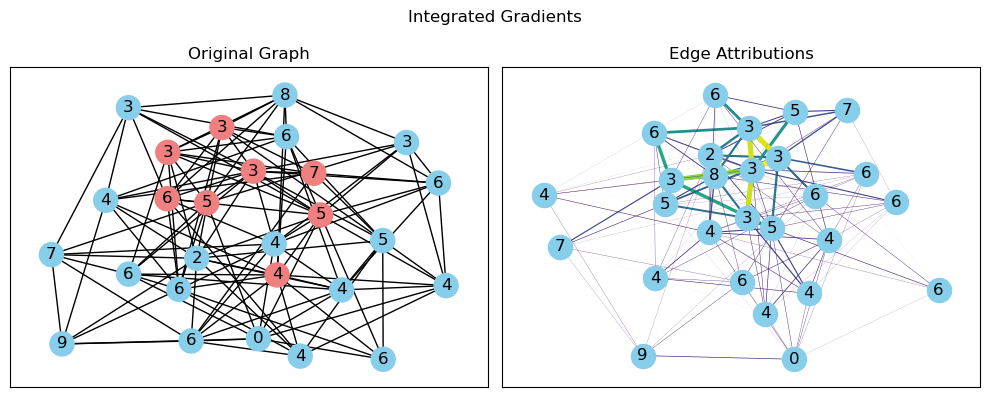

In [58]:
# Get an example input from your dataset
input_data = train_dataset[0]
# print(input_data.x)
input_data = input_data.to(device)
attributions = explain(method='ig', data=input_data, target=0)
# print('Attributions:', attributions)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Integrated Gradients")
visualize_graph(input_data, ax[0])
# Visualize attributions for the example data
visualize_attributions(input_data, attributions, ax[1])
plt.tight_layout()
plt.show()

/var/folders/27/zfxsglqs1dz7r2s38wpgb8b88zxvq5/T/ipykernel_74911/3274526301.py:49: RuntimeWarning: invalid value encountered in scalar divide
  edge_weights = [4 * w / max(edge_weights) for w in edge_weights]


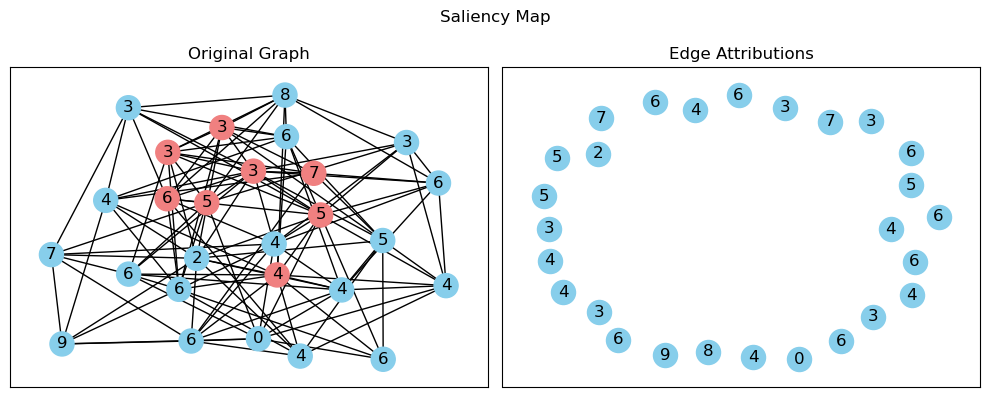

In [60]:
# Get an example input from your dataset
input_data = train_dataset[0]
input_data = input_data.to(device)
attributions = explain(method='saliency', data=input_data, target=0)
# print('Attributions:', attributions)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Saliency Map")
visualize_graph(input_data, ax[0])
# Visualize attributions for the example data
visualize_attributions(input_data, attributions, ax[1])
plt.tight_layout()
plt.show()